In [1]:
cd /content/drive/MyDrive/Pytorch/UNET

/content/drive/MyDrive/Pytorch/UNET


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms.functional as TF


def DoubleConv2D(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True))

def copy_and_crop(input_tensors, target_tensors):
    target_size = target_tensors.size()[2]
    input_size = input_tensors.size()[2]

    required = input_size-target_size
    delta = required//2
    return input_tensors[:, :, delta:input_size-delta, delta:input_size-delta]

class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(Unet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Contracting Path or Down Parts
        for feature in features:
            self.downs.append(DoubleConv2D(in_channels, feature))
            in_channels = feature

         #for feature in reversed(features):
        for feature in features[::-1]:
            self.ups.append(
                nn.ConvTranspose2d(
                feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(
                DoubleConv2D(feature*2, feature)
            )

        self.bottleneck = DoubleConv2D(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.max_pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape!= skip_connection.shape:
                #x = TF.resize(x, size=skip_connection.shape[2:])
                x = copy_and_crop(x, skip_connection)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


x = torch.randn((3, 1, 160, 160))
model = Unet(in_channels=1, out_channels=1)
y = model(x)
print(x.size())
print(y.size())


torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Unet(in_channels=3, out_channels=1).to(device)

In [4]:
ls

my_checkpoint.pth.tar  Untitled0.ipynb  vall/


In [5]:
checkpoint = torch.load("my_checkpoint.pth.tar", map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.to(device)

Unet(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): Sequential(
      (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): Sequential(
      (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
learning_rate = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
num_epochs = 10
num_workers = 2
image_height = 160
image_width = 240
PIN_MEMORY = True
LOAD_MODEL = False

val_transforms = A.Compose(
        [
        A.Resize(height=image_height, width=image_width),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std = [1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2(),

        ]
    )

In [39]:
from PIL import Image
import numpy as np
img_path = "vall/val/03a857ce842d_15.jpg"
mask_path = "vall/val_masks/03a857ce842d_15_mask.gif"
image = np.array(Image.open(img_path).convert("RGB"))
mask = np.array(Image.open(mask_path).convert("L"))
img = val_transforms(image=image)
print(img)

{'image': tensor([[[0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6824, 0.6902, 0.6902],
         [0.6980, 0.6980, 0.6980,  ..., 0.6824, 0.6902, 0.6902],
         [0.6980, 0.6980, 0.6863,  ..., 0.6824, 0.6824, 0.6824]],

        [[0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9490],
         [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9490],
         [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9490],
         ...,
         [0.7137, 0.7137, 0.7137,  ..., 0.6980, 0.7059, 0.7059],
         [0.7137, 0.7137, 0.7137,  ..., 0.6980, 0.7059, 0.7059],
         [0.7137, 0.7137, 0.7020,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.9333, 0.9333, 0.9333,  ..., 0.9490, 0.9490, 0.9490],
         [0.9333, 0.9333, 0.9333,  ..., 0.9490, 0.9490, 0.9490],
         [0.9333, 0.9333, 0.9333,  ..., 0.9490, 

In [8]:
img = img['image']

In [9]:
img.shape

torch.Size([3, 160, 240])

In [10]:
img = img.to(device)

In [11]:
image1 = torch.unsqueeze(img, 0)
image1.shape

torch.Size([1, 3, 160, 240])

In [12]:
image1 = image1.to(device)

In [14]:
prediction = torch.sigmoid(model(image1))

In [27]:
print(prediction)
print(prediction.size())

tensor([[[[0.0420, 0.0359, 0.0292,  ..., 0.0202, 0.0209, 0.0319],
          [0.0254, 0.0213, 0.0225,  ..., 0.0242, 0.0188, 0.0261],
          [0.0216, 0.0259, 0.0249,  ..., 0.0367, 0.0204, 0.0204],
          ...,
          [0.0172, 0.0135, 0.0176,  ..., 0.0187, 0.0202, 0.0219],
          [0.0199, 0.0100, 0.0115,  ..., 0.0150, 0.0138, 0.0266],
          [0.0387, 0.0240, 0.0185,  ..., 0.0211, 0.0263, 0.0488]]]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
torch.Size([1, 1, 160, 240])


In [29]:
import matplotlib.pyplot as plt
a = torch.squeeze(prediction, 0)
b = torch.squeeze(prediction, 0)
c = prediction.squeeze(0).cpu().detach().numpy()

In [31]:
print(c.shape)

(1, 160, 240)


In [32]:
output = np.transpose(c, (1, 2, 0))

In [35]:
output.shape

(160, 240, 1)

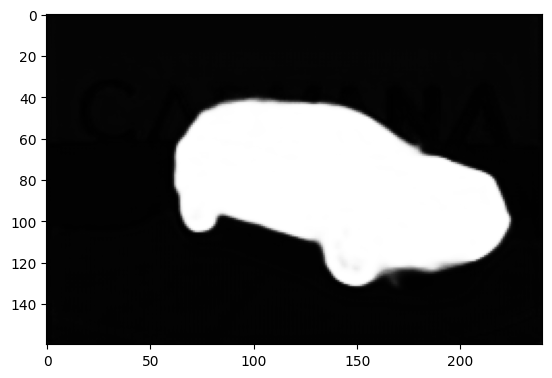

In [37]:
plt.imshow(output, cmap="gray")

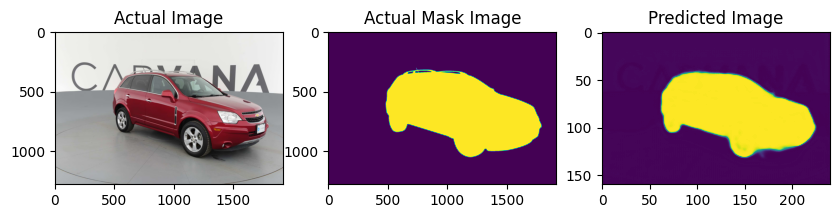

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs[0].imshow(np.array(Image.open(img_path).convert("RGB")))
axs[0].set_title('Actual Image')
axs[1].imshow(mask)
axs[1].set_title('Actual Mask Image')
axs[2].imshow(output)
axs[2].set_title('Predicted Image')
plt.show()

{'image': tensor([[[0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6824, 0.6902, 0.6902],
         [0.6980, 0.6980, 0.6980,  ..., 0.6824, 0.6902, 0.6902],
         [0.6980, 0.6980, 0.6863,  ..., 0.6824, 0.6824, 0.6824]],

        [[0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9490],
         [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9490],
         [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9490],
         ...,
         [0.7137, 0.7137, 0.7137,  ..., 0.6980, 0.7059, 0.7059],
         [0.7137, 0.7137, 0.7137,  ..., 0.6980, 0.7059, 0.7059],
         [0.7137, 0.7137, 0.7020,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.9333, 0.9333, 0.9333,  ..., 0.9490, 0.9490, 0.9490],
         [0.9333, 0.9333, 0.9333,  ..., 0.9490, 0.9490, 0.9490],
         [0.9333, 0.9333, 0.9333,  ..., 0.9490, 

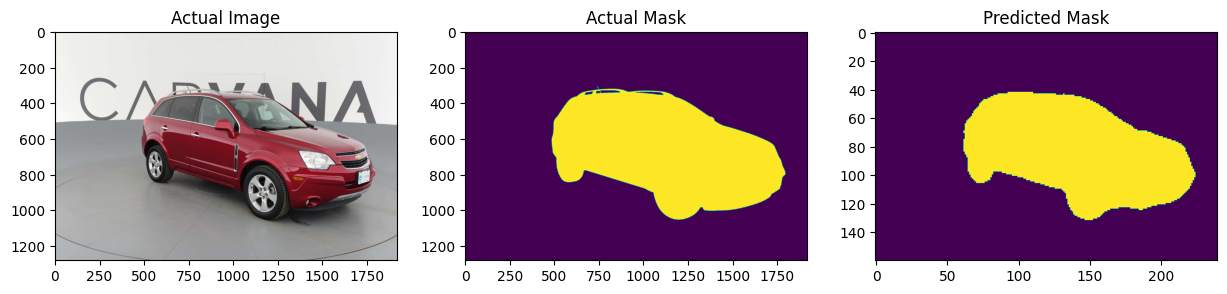

<Figure size 640x480 with 0 Axes>

In [42]:
def infer_and_visualize(model, image_path, mask_path, transform = val_transforms, device="cuda"):
  image = np.array(Image.open(image_path).convert("RGB"))
  mask = np.array(Image.open(mask_path).convert("L"))
  img = val_transforms(image=image)
  print(img)
  img = img['image']
  img = img.to(device)
  image1 = torch.unsqueeze(img, 0)
  image1 = image1.to(device)
  prediction = torch.sigmoid(model(image1))
  prediction = (prediction > 0.5).float()
  prediction = prediction.squeeze(0).cpu().detach().numpy()
  output = np.transpose(prediction, (1, 2, 0))

  fig, axs = plt.subplots(1, 3, figsize=(15, 10))
  axs[0].imshow(image)
  axs[0].set_title('Actual Image')
  #axs[1].imshow(mask, cmap='gray')
  axs[1].imshow(mask)
  axs[1].set_title('Actual Mask')
  #axs[2].imshow(output, cmap='gray')
  axs[2].imshow(output)
  axs[2].set_title('Predicted Mask')
  plt.show()
  plt.savefig("inference_result.png")


img_path = "vall/val/03a857ce842d_15.jpg"
mask_path = "vall/val_masks/03a857ce842d_15_mask.gif"
infer_and_visualize(model, img_path, mask_path, transform = val_transforms, device="cuda")

